# Identifying sentences that convey meaningful semantic relation between entities within the sentence - Exploratory Data Analysis (EDA)


The objective of this notebook is to present a brief exploratory data analysis (EDA) of the sampled dataset that will be later used.

In [13]:
from IPython.display import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from scipy.stats import powerlaw
import numpy as np

## Part 1: Named Entities EDA

The Named Entities analysis was conducted during the dataset generation.
The distribution of named entity occurances, along with their corresponding labels, follows a heavy-tail distibution pattern, as can be seen below:

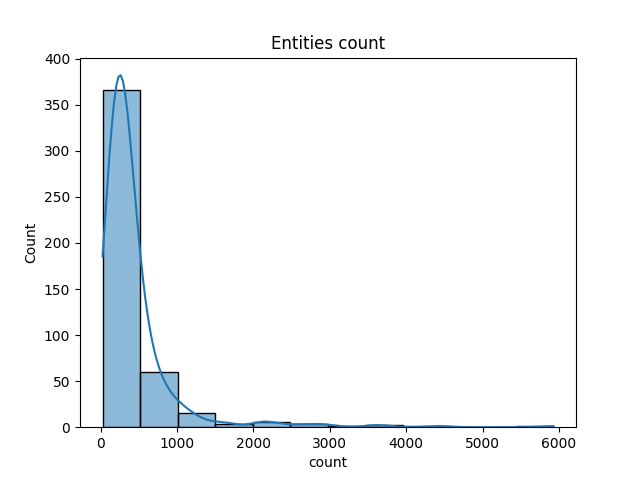

In [14]:
Image(filename='./sampled_sentences_stats/entities_count.png')

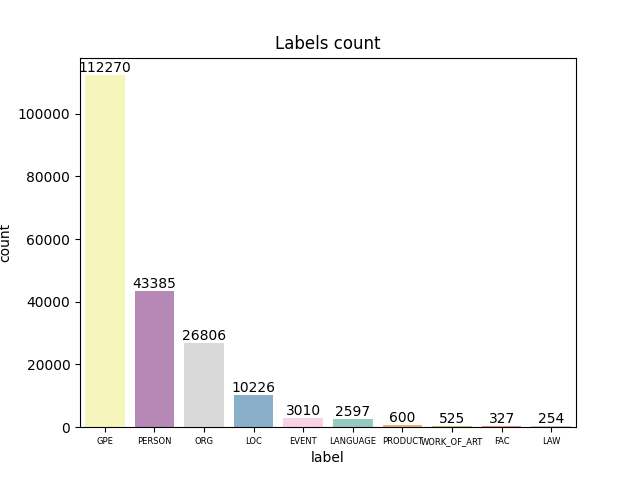

In [15]:
Image(filename='./sampled_sentences_stats/labels_count.png')

We can see that Named-entities pairs follow a heavy-tail distibution as well:

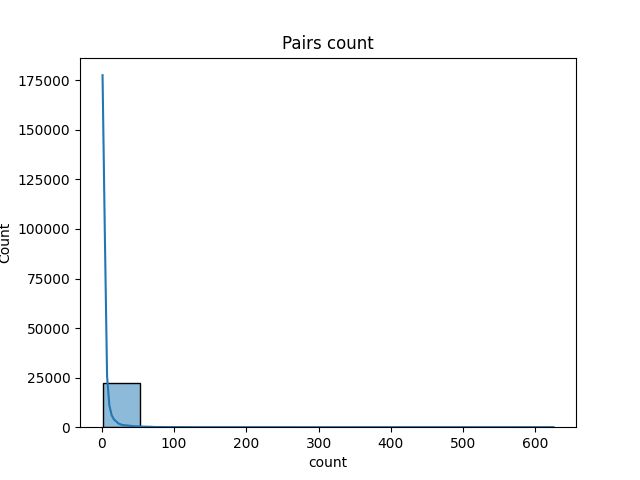

In [16]:
Image(filename='./sampled_sentences_stats/pairs_count.png')

The occurrences of the paired labels can be visualized using a heatmap. For instance, it can be observed that pairs labeled as GPE-GPE (geopolitical entities) are the most common.

Other frequent combinations include: GPE-LOC (geopolitical entity - location), GPE-ORG (geopolitical entity - organization), GPE-PERSON, LOC-LOC (location - location), ORG-ORG (organization - organization), ORG-PERSON, and PERSON-PERSON.

*Notes:*

* In this context, each pair is counted twice due to the symmetric nature of the relation. For example, a pair consisting of GPE and PERSON will be counted once as (GPE, PERSON) and then again as (PERSON, GPE).

* In the original dataset, there were more occurrences of the PERSON-PERSON relation compared to the GPE-GPE relation. However, in the sampled dataset, this relation is reversed. One possible explanation for this is that names of individual people are fewer by nature compared to names of places. As a result, fewer person named entities met the requirement of appearing more than 1000 times in the texts.


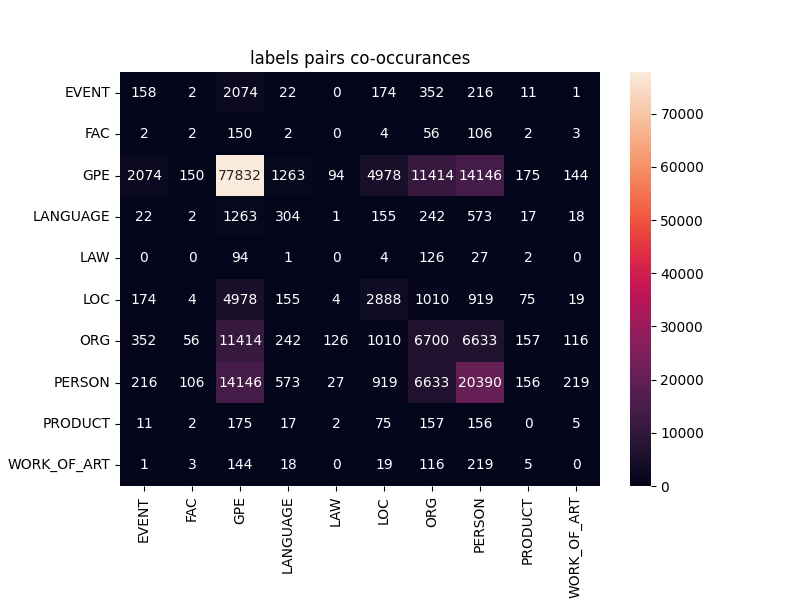

In [17]:
Image(filename='./sampled_sentences_stats/pairs_labels_count.png')

## Part 2: Exploring the Mutual Information (MI) Score

### Exploring the MI for the entire dataset

The mutual information (MI) analysis also reveals a clear power-law distribution. It is apparent that lower MI values occur frequently, indicating a lower level of relationship between the entities. Conversely, entities with a higher level of relationship are less common.

In [18]:
dataset_path = '../data/data.csv'
df = pd.read_csv(dataset_path)

In [19]:
df['mi_score'].describe()

count    1.000000e+05
mean     5.108566e-05
std      1.524931e-04
min      5.764400e-09
25%      3.486411e-07
50%      3.430368e-06
75%      3.035476e-05
max      1.185945e-03
Name: mi_score, dtype: float64

Text(0.5, 1.0, 'Mutial information distribution')

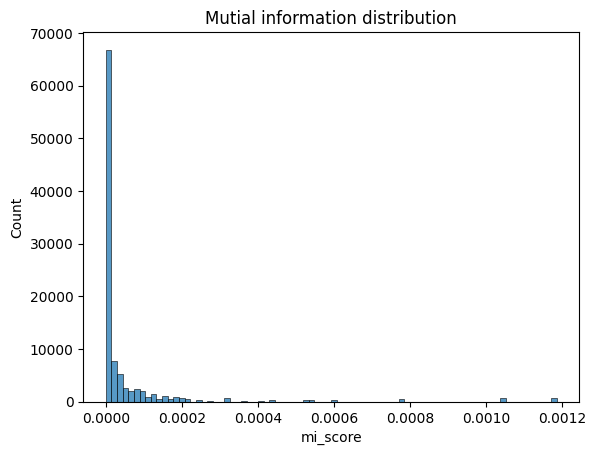

In [20]:
sns.histplot(data=df['mi_score'], kde=False, binrange=(min(df['mi_score']), max(df['mi_score'])), bins=80)
plt.title('Mutial information distribution')

### Estimating Probability Distribution for MI

To estimate the probability, we will fit the parameters of a power-law distribution:

In [21]:
def fit_powerlaw_dist(values):
    fit_params = powerlaw.fit(values)
    fitted_distribution = powerlaw(*fit_params)
    return fitted_distribution

In [22]:
def plot_fitted_dist(values, fitted_distribution, label, bins=80):
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(values, bins=bins, density=False, alpha=0.5, label=label)
    # Plot the fitted distribution using the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    fitted_pdf = fitted_distribution.pdf(bin_centers)
    ax.plot(bin_centers, fitted_pdf, color='r', label='Fitted Power-law Distribution')

    plt.title(f'Histogram of {label}')
    plt.xlabel(label)
    plt.ylabel('Frequency')

    plt.legend()
    plt.show()

In [23]:
def create_fitted_precentiles(values, fitted_distribution):
    percentiles = np.arange(10, 110, 10)  # Generate an array from 10 to 100 in increments of 10
    data_percentiles = np.percentile(values, percentiles)
    distribution_precentiles = [fitted_distribution.ppf(p / 100) for p in percentiles]

    precentiles_df = pd.DataFrame({
        'Percentile': percentiles,
        'data percentiles': data_percentiles,
        'distribution precentiles': distribution_precentiles
    }).set_index('Percentile')

    return precentiles_df

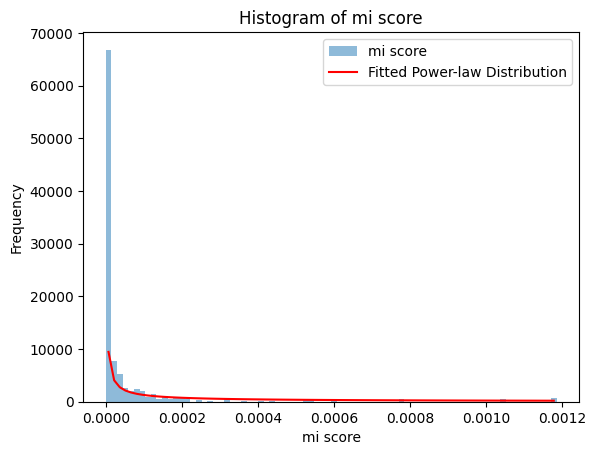

            data percentiles  distribution precentiles
Percentile                                            
10              4.815523e-08              6.937012e-08
20              2.037102e-07              1.264000e-06
30              5.732581e-07              7.217316e-06
40              1.444532e-06              2.489592e-05
50              3.430368e-06              6.506844e-05
60              8.307251e-06              1.426632e-04
70              1.951063e-05              2.770659e-04
80              4.474167e-05              4.923777e-04
90              1.190581e-04              8.176441e-04
100             1.185945e-03              1.287062e-03


In [24]:
scores = df['mi_score']
fitted_dist = fit_powerlaw_dist(scores)
plot_fitted_dist(scores, fitted_dist, 'mi score')
print(create_fitted_precentiles(scores, fitted_dist))

### Pairs with highest and lowest MI score

In [25]:
sorted_df = df.sort_values(by='mi_score', ascending=False)

The 5 pairs with highest MI score:

In [47]:
for index, s in sorted_df.head(5).iterrows():
    print(f'{s.sent_id} {s.ent1} {s.label1} {s.ent2} {s.label2} {s.mi_score:.5f} {s.sent}')

245093 Gilbert PERSON Sullivan PERSON 0.00053 Professor Carolyn Williams has noted, however: "The influence of Gilbert and Sullivan – their wit and sense of irony, the send ups of politics and contemporary culture – goes beyond musical theater to comedy in general.
244993 Gilbert PERSON Sullivan PERSON 0.00053 Gilbert did not feel that he could write a grand opera libretto, but he offered a compromise that Sullivan ultimately accepted.
245007 Gilbert PERSON Sullivan PERSON 0.00053 Gilbert and Sullivan sometimes had a strained working relationship, partly caused by the fact that each man saw himself as allowing his work to be subjugated to the other's, and partly caused by the opposing personalities of the two — Gilbert was often confrontational and notoriously thin-skinned (though prone to acts of extraordinary kindness), while Sullivan eschewed conflict.
245011 Gilbert PERSON Sullivan PERSON 0.00053 Gilbert and Sullivan disagreed several times over the choice of a subject.
245012 Sull

The 5 pairs with lowest MI score:

In [27]:
for index, s in sorted_df.tail(5).iterrows():
    print(f'{s.sent_id} {s.ent1} {s.label1} {s.ent2} {s.label2} {s.mi_score:.5f} {s.sent}')

2604856 Moon PERSON Mitchell PERSON 0.00000 During an Inside Soap feature on the Moon brothers vs the Mitchell brothers, Kate Woodward said "Two sexy brothers to shake up Albert Square?
1453937 Barcelona GPE YouTube ORG 0.00000 During the 2010 Sant Jordi festivities in Barcelona, the (350 +) staff in one of the main buildings of the Polytechnic University of Catalonia used the ostensibly massive amounts of free time available to them to perform a notorious lip dub of the song that reached over 150000 views on YouTube.
966689 Burns PERSON Love WORK_OF_ART 0.00000 Mr. Burns himself has been involved with several women and in "A Hunka Hunka Burns in Love", Smithers is noticeably disgusted when Mr. Burns starts looking for a female companion.
234419 Lucas PERSON Bush PERSON 0.00000 Despite Lucas' insistence to the contrary, The Seattle Times concluded, "Without naming Bush or the Patriot Act, it's all unmistakable no matter what your own politics may be."
2687269 Stewart PERSON Yankees ORG

### Exploring the MI for each labels-pair

I decided to display only the top 8 label pairs in the dataset for mutual information (MI) analysis. As expected, we often observe a power-law distribution, with an additional cluster representing the pairs that frequently appeared together.

In [28]:
def plot_type_mi_hist_plot(df, type1, type2, bins='auto'):
    df1 = df[( (df['label1'] == type1) & (df['label2'] == type2) ) | ( (df['label2'] == type1) & (df['label1'] == type2) )]
    sns.histplot(data=df1['mi_score'], kde=False, bins=bins)
    plt.title(f'Mutial information distribution for labels: {type1}-{type2}')

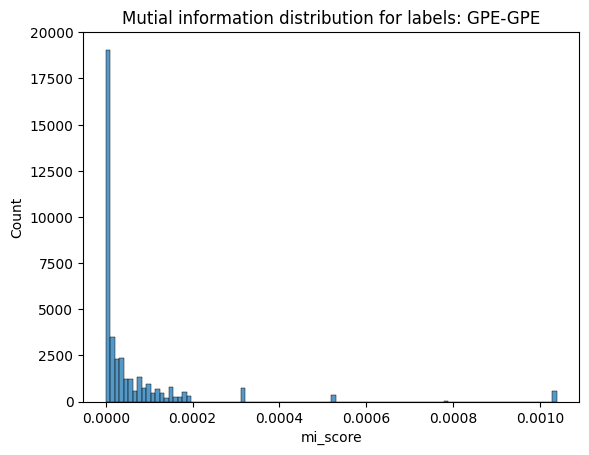

In [29]:
plot_type_mi_hist_plot(df, 'GPE', 'GPE', bins=100)

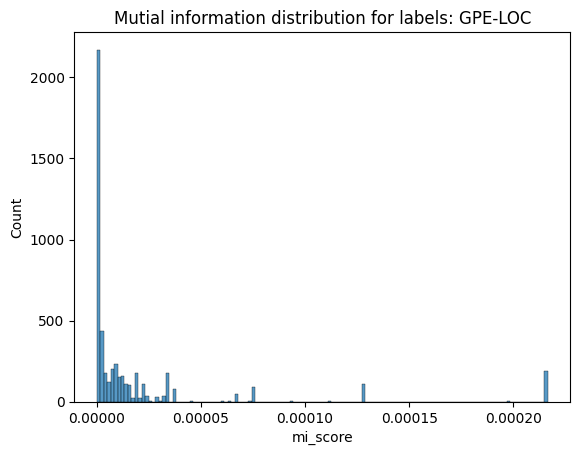

In [30]:
plot_type_mi_hist_plot(df, 'GPE', 'LOC')

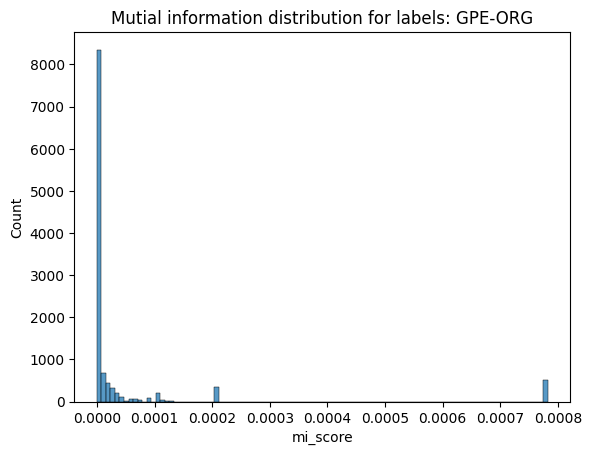

In [382]:
plot_type_mi_hist_plot(df, 'GPE', 'ORG', bins=100)

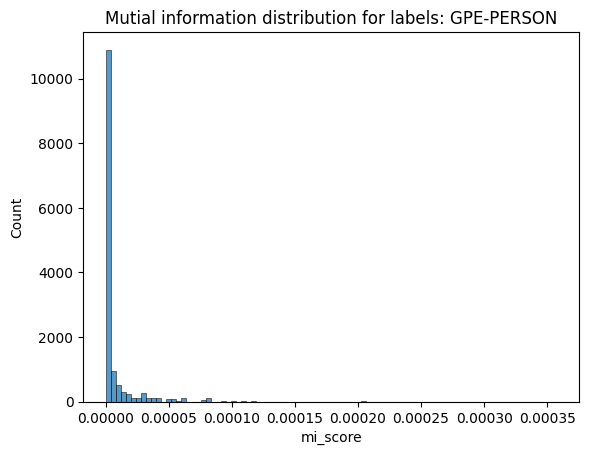

In [31]:
plot_type_mi_hist_plot(df, 'GPE', 'PERSON', bins=90)

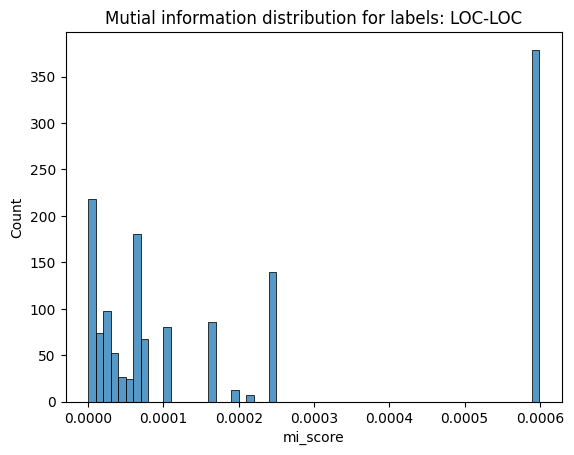

In [32]:
plot_type_mi_hist_plot(df, 'LOC', 'LOC', bins=60)

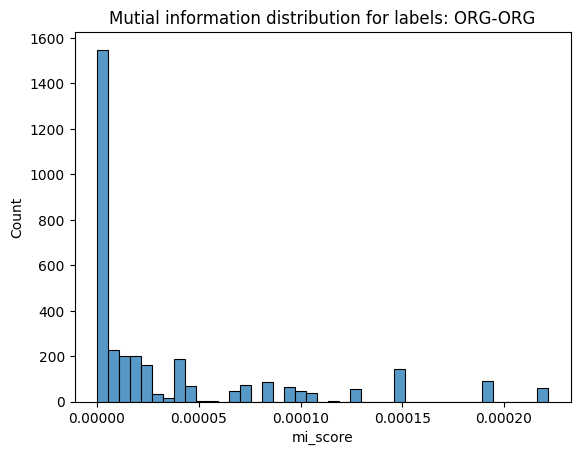

In [33]:
plot_type_mi_hist_plot(df, 'ORG', 'ORG')

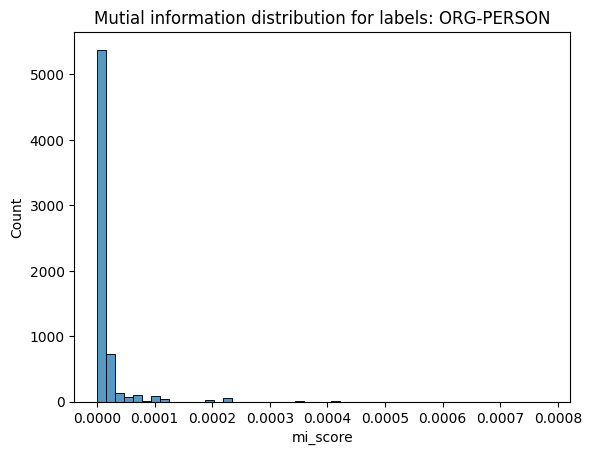

In [34]:
plot_type_mi_hist_plot(df, 'ORG', 'PERSON', bins=50)

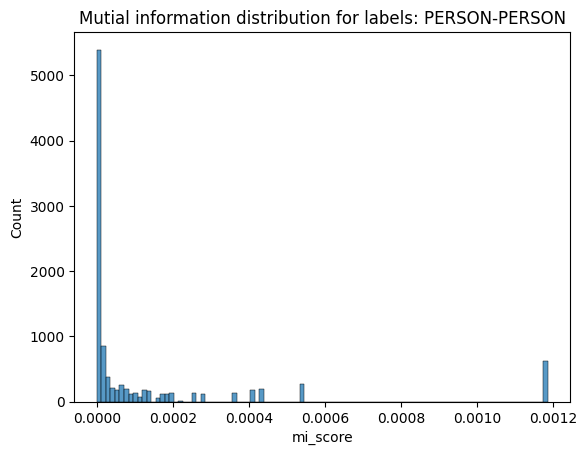

In [35]:
plot_type_mi_hist_plot(df, 'PERSON', 'PERSON', bins=100)

## Part 3: Exploring the Pointwise Mutual Information (PMI) Score

### Exploring the PMI for the entire dataset

The distribution of PMI values demonstrates a bell-shaped pattern.

Text(0.5, 1.0, 'PMI distribution')

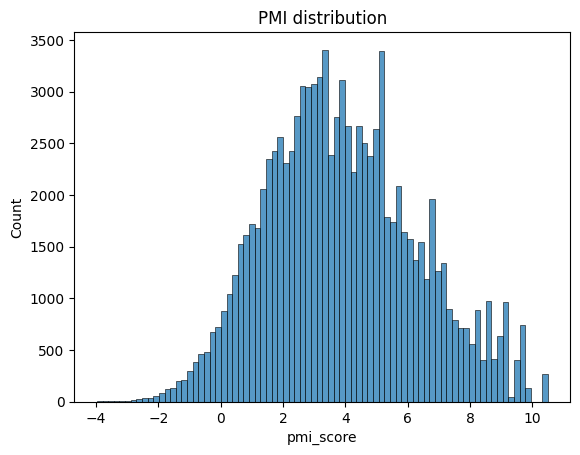

In [36]:
sns.histplot(data=df['pmi_score'], kde=False, binrange=(min(df['pmi_score']), max(df['pmi_score'])), bins=80)
plt.title('PMI distribution')

In [37]:
sorted_df = df.sort_values(by='pmi_score', ascending=False)

In [38]:
print(f"min pmi score: {min(df['pmi_score'])}, max pmi score: {max(df['pmi_score'])}")
print(f"pmi range: {max(df['pmi_score']- min(df['pmi_score']))}")

min pmi score: -3.972599988657268, max pmi score: 10.496448647043133
pmi range: 14.4690486357004


### Pairs with highest and lowest PMI score

In [39]:
sorted_df = df.sort_values(by='pmi_score', ascending=False)

The 5 pairs with highest PMI score:

In [40]:
for index, s in sorted_df.head(5).iterrows():
    print(f'{s.sent_id} {s.ent1} {s.label1} {s.ent2} {s.label2} {s.pmi_score} {s.sent}')

245093 Gilbert PERSON Sullivan PERSON 10.496448647043133 Professor Carolyn Williams has noted, however: "The influence of Gilbert and Sullivan – their wit and sense of irony, the send ups of politics and contemporary culture – goes beyond musical theater to comedy in general.
244993 Gilbert PERSON Sullivan PERSON 10.496448647043133 Gilbert did not feel that he could write a grand opera libretto, but he offered a compromise that Sullivan ultimately accepted.
245007 Gilbert PERSON Sullivan PERSON 10.496448647043133 Gilbert and Sullivan sometimes had a strained working relationship, partly caused by the fact that each man saw himself as allowing his work to be subjugated to the other's, and partly caused by the opposing personalities of the two — Gilbert was often confrontational and notoriously thin-skinned (though prone to acts of extraordinary kindness), while Sullivan eschewed conflict.
245011 Gilbert PERSON Sullivan PERSON 10.496448647043133 Gilbert and Sullivan disagreed several tim

Let's examine 'Gilbert' and 'Sullivan' co-occurances in the sampled dataset as the pair with top PMI score:

In [42]:
def get_coappearnce_count(df, ent1, ent2):
    return len(sorted_df[(df['ent1'] == ent1) & (sorted_df['ent2'] == ent2)]) + \
            len(sorted_df[(df['ent1'] == ent2) & (sorted_df['ent2'] == ent1)])

def get_separate_coappearnce_count(df, ent1, ent2):
    ent1_count = len(sorted_df[(df['ent1'] == ent1) & (sorted_df['ent2'] != ent2)]) + \
            len(sorted_df[(df['ent1'] != ent2) & (sorted_df['ent2'] == ent1)])
    ent2_count = len(sorted_df[(df['ent1'] != ent1) & (sorted_df['ent2'] == ent2)]) + \
            len(sorted_df[(df['ent1'] == ent2) & (sorted_df['ent2'] != ent1)])
    return ent1_count, ent2_count

ent1 = 'Gilbert'
ent2 = 'Sullivan'
coappearnce = get_coappearnce_count(sorted_df, ent1, ent2)

print(f'co-apperances: {coappearnce}')

ent1_appearance, ent2_appearance = get_separate_coappearnce_count(sorted_df, ent1, ent2)
print(f'{ent1} appeared without {ent2} {ent1_appearance} times')
print(f'{ent2} appeared without {ent1} {ent2_appearance} times')

co-apperances: 263
Gilbert appeared without Sullivan 108 times
Sullivan appeared without Gilbert 116 times


The 5 pairs with lowest PMI score:

In [43]:
for index, s in sorted_df.tail(5).iterrows():
    print(f'{s.sent_id} {s.ent1} {s.label1} {s.ent2} {s.label2} {s.pmi_score} {s.sent}')

1894612 India GPE India PERSON -3.786113180283036 Fahad Usmani of The Hindu compared Siva to Mother India (1957), Sholay (1975), Mr. India (1987), Agneepath (1990), and Ghayal (1990), noting that their antagonists became more popular than their heroes.
1173351 IGN ORG England GPE -3.845993044349744 IGN's Jeremy Dunham noted that "Clock Tower 3 successfully captur [es] the dirty, musty look of England's serial killer underworld... [it] is straight out of a Mary Shelley novel."
1984090 England PERSON England GPE -3.957206376425851 Back in England, Trescothick was called upon to captain England after Michael Vaughan sustained a knee injury.
1521614 England GPE England PERSON -3.957206376425851 England won the match to take the series 3 – 2, amid great public interest in England and Australia.
339069 New York GPE New York ORG -3.972599988657268 Fallout over the program led to litigation between New York and Amtrak; Amtrak would eventually pay New York $20 million and commit to funding $10 

## Part 4: Exploring the correlation between PMI and MI

We can see that the correlation is low:

In [395]:
correlation = sorted_df['mi_score'].corr(sorted_df['pmi_score'])
print(f"Correlation between 'mi_score' and 'pmi_score': {correlation}")

Correlation between 'mi_score' and 'pmi_score': 0.11613868306758517


## Part 5: Exploring sentences length

<AxesSubplot: >

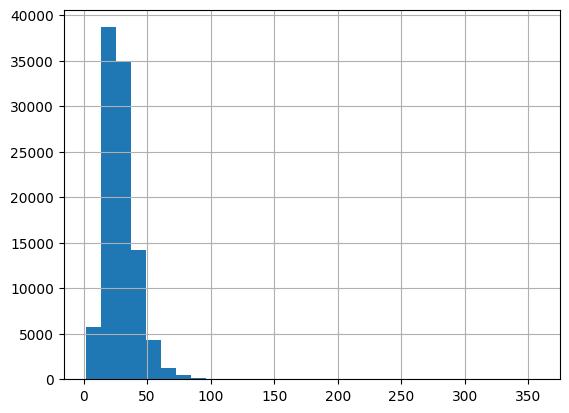

In [396]:
seq_len = [len(i.split()) for i in df['sent']]

pd.Series(seq_len).hist(bins = 30)